# Script to peform a simple Bayesian inference of mass and concetration from a Navarro-Frenk-White profile to a stack weak lensing data

 The input it is a fit file with
 
 - $R$ [Mpc], 
 - $\Delta\Sigma$ [$M_{\odot} pc^2$], 
 - $\Delta\Sigma_{err}$ [$M_{\odot} pc^2$].
 
 
 The output are the "best" values for mass $(M_{200})$ and concentration $(c)$,
 according to a simple Bayesian inference approach.
 
 The script depends on the NFW.py module from joergdietrich (at Github):
 https://github.com/joergdietrich/NFW/blob/master/nfw.py

In [30]:
#!/bin/env python
#==========================
# author: Maria Elidaiana
# email: mariaeli@cbpf.br
# Script based on: 
# https://github.com/drphilmarshall/StatisticalMethods/blob/b9f481876c002cb210375e07783d6515ed536cca/examples/Cepheids/PeriodMagnitudeRelation.ipynb
#==========================

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM  # The default cosmology is: astropy.cosmology.default_cosmology.get()
from scipy.stats import norm
from NFW.nfw import NFW

from astropy.table import Table, vstack      # Use tables instead of recarrays from fits

get_ipython().magic(u'matplotlib inline')
plt.rcParams['figure.figsize'] = (15.0, 9.0)

In [3]:
stacked_clusters = Table.read('./DS_l4/results2fit.fits')
print(stacked_clusters)                      # Check the data

    Radius     Delta_Sigma_T  ...  Delta_Sigma_X  err_Delta_Sigma_X
-------------- -------------- ... --------------- -----------------
           0.1 -113.692461356 ...    150.70816972     230.261760208
 0.12742749857   -119.1124732 ...   149.730147479      196.46117599
0.162377673919  238.645670861 ...  -9.91361205935     123.373471171
0.206913808111  159.940890345 ...   23.2464616234     90.9806852516
0.263665089873  324.025554405 ...   -29.884200742     88.4568157037
0.335981828628  174.054832204 ...   13.3549014394     94.8756435659
0.428133239872  118.912586006 ...   75.5117413139     50.6691236052
0.545559478117  95.8076612929 ...   65.8005899751     36.7545307064
0.695192796178  114.235738068 ...  -23.2264548237     22.9972146552
 0.88586679041  102.016679003 ...   28.6174628011     30.7292777067
 1.12883789168  81.7849838763 ...  -22.5967576614     22.9939347304
 1.43844988829  63.7050603468 ...  -1.82355703144     18.1096541934
 1.83298071083  36.3885016827 ...  -8.9969612327

In [4]:
R     = np.array(stacked_clusters['Radius'])
DSobs = np.array(stacked_clusters['Delta_Sigma_T'])
DSerr = np.array(stacked_clusters['err_Delta_Sigma_T'])

fitmask = (R>=0.3)&(R<3.5)
print(stacked_clusters[fitmask])

R = R[fitmask]
DSobs = DSobs[fitmask]
DSerr = DSerr[fitmask]
print(R,DSobs)

z_mean = 0.215

    Radius     Delta_Sigma_T err_Delta_Sigma_T Delta_Sigma_X  err_Delta_Sigma_X
-------------- ------------- ----------------- -------------- -----------------
0.335981828628 174.054832204     48.4188536004  13.3549014394     94.8756435659
0.428133239872 118.912586006     32.9861112341  75.5117413139     50.6691236052
0.545559478117 95.8076612929     41.5604005037  65.8005899751     36.7545307064
0.695192796178 114.235738068     37.3843248661 -23.2264548237     22.9972146552
 0.88586679041 102.016679003     21.1670304168  28.6174628011     30.7292777067
 1.12883789168 81.7849838763     22.3110354742 -22.5967576614     22.9939347304
 1.43844988829 63.7050603468     21.0942235438 -1.82355703144     18.1096541934
 1.83298071083 36.3885016827     12.2282959478 -8.99696123277     15.2722074785
 2.33572146909 37.2290402535     11.0591268235 -24.1307361254      7.4492217973
 2.97635144163  30.750423601     9.61569123782 -2.92327080489     6.40527520287
(array([ 0.33598183,  0.42813324,  0.545

In [5]:
# NFW module that compute the \Delta\Sigma from theory

def DStheo(R, theta):
    m200,c = theta    
    nfw = NFW(m200, c, z_mean, cosmology=FlatLambdaCDM(H0=100, Om0=0.3)) # can change cosmology, overdensity...  
    ds  = nfw.delta_sigma(R)                                             # in units of solMass/Mpc^2
    return np.array(ds.value/1.e12)                                      # in units of solMass/pc^2


#print(DStheo(R, (1e14, 4))) # theta = (m200,c)

In [33]:

# Defining the likelihoods...

def nfw_log_likelihood(R, DSobs, DSerr, theta):
    #print(theta)
    #m200, c = theta
    return -0.5*np.sum(( DSobs - DStheo(R, theta) )**2/(DSerr**2))

def nfw_log_prior(theta, theta_limits):
    
    m200, c = theta 
    
    m200limits, climits = theta_limits
    
    #m200min, m200max = 1e13, 1e15   
    #cmin, cmax = 1, 20
    
    m200min, m200max = theta_limits[0][0], theta_limits[0][1] 
    cmin, cmax = theta_limits[1][0], theta_limits[1][1] 
    
    #print(m200min,m200max)
    #print(cmin,cmax)

    if (m200<m200min)|(m200>m200max):
        log_m200_prior = -np.inf
    else:
        log_m200_prior = -np.log(m200max-m200min)
        
    if (c<cmin)|(c>cmax):
        log_c_prior = -np.inf
    else:
        log_c_prior = -np.log(cmax-cmin)
        
    return log_m200_prior+log_c_prior
    
def nfw_log_posterior(R, DSobs, DSerr, theta):
    m200, c = theta
    return nfw_log_likelihood(R, DSobs, DSerr, theta) + nfw_log_prior(theta, theta_limits)


('Grid maximum posterior values (m200,c) =', 158500000000000.0, 2.7999999999999998)


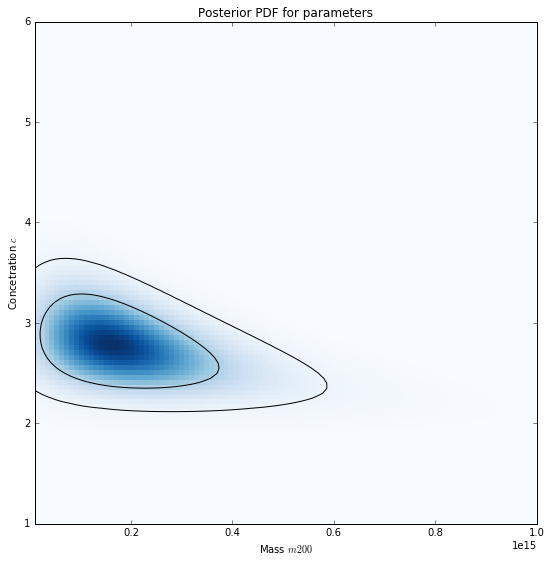

In [36]:
#Set up contour level plot

def plot_mb_setup(mlimits,climits):
    plt.xlabel('Mass $m200$')
    plt.ylabel('Concetration $c$')
    plt.axis([mlimits[0],mlimits[1], climits[0],climits[1]])
    
def pdf_contour_levels(p):
    sortp = np.sort(p.ravel())
    cump = sortp.cumsum()
    return [sortp[cump > cump.max() * f].min()
            #for f in [0.32, 0.05]]
            for f in [0.05, 0.32]] #countourplots fucntion must use 95 and 68 conf. level
    
# Set up parameter grids:

npix = 101
m200limits = [1e13, 1e15]
climits = [1, 6]
theta_limits = (m200limits, climits) 


m200grid = np.linspace(m200limits[0], m200limits[1], npix)
cgrid = np.linspace(climits[0], climits[1], npix)
log_posterior = np.zeros((len(m200grid),len(cgrid)))

# Evaluate log posterior PDF:
for im200,m200 in enumerate(m200grid):
    for ic,c in enumerate(cgrid):
        theta = (m200,c)
        log_posterior[im200,ic] = nfw_log_posterior(R,DSobs,DSerr,theta)

# Convert to probability density and plot, taking care with very small values:

posterior = np.exp(log_posterior - log_posterior.max())

plt.imshow(posterior, extent=[m200limits[0],m200limits[1],climits[0],climits[1]],cmap='Blues',
           interpolation='none', origin='lower', aspect=(m200limits[1]-m200limits[0])/(climits[1]-climits[0]),
           vmin=0, vmax=1)
plt.contour(m200grid, cgrid, posterior, pdf_contour_levels(posterior), colors='k')

i = np.argmax(posterior)
i,j = np.unravel_index(i, posterior.shape)
print('Grid maximum posterior values (m200,c) =', m200grid[j], cgrid[i])

plt.title('Posterior PDF for parameters')
plot_mb_setup(*theta_limits)

# Plot 1D distributions:

* PDF plots for m200 and c

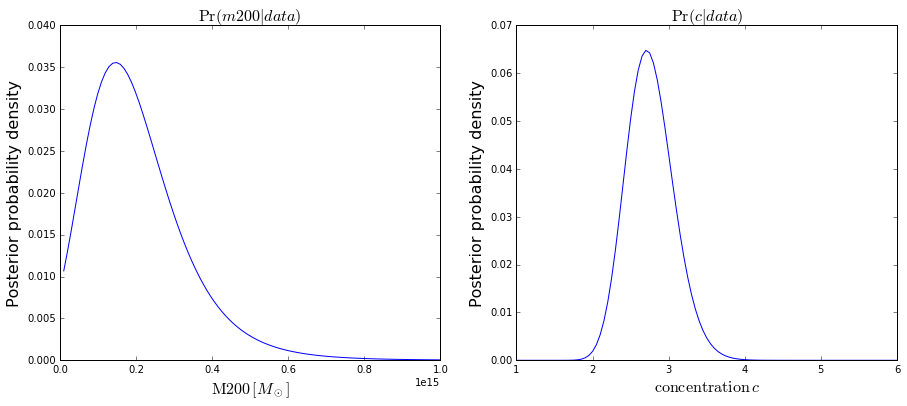

In [38]:
# Normalizing...

prob = posterior
norm = np.sum(prob)
prob /= norm 

prob_m200_given_data = np.sum(prob,axis=0)
prob_c_given_data = np.sum(prob,axis=1)

fig,ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
plt.subplots_adjust(wspace=0.2)

# Plot 1D distributions:

left = ax[0].plot(m200grid, prob_m200_given_data)
ax[0].set_title(r'${\rm Pr}(m200|data)$', fontsize=16)
ax[0].set_xlabel(r'$ {\rm M200} \, [M_\odot]$', fontsize=16)
ax[0].set_ylabel('Posterior probability density', fontsize=16)

right = ax[1].plot(cgrid, prob_c_given_data)
ax[1].set_title(r'${\rm Pr}(c|data)$', fontsize=16)
ax[1].set_xlabel(r'$ {\rm concentration} \, c $', fontsize=16)
ax[1].set_ylabel('Posterior probability density', fontsize=16)
plt.show()


In [39]:
# Determining errors...

def compress_1D_pdf(x,pr,ci=68,dp=1):
    
    # Interpret credible interval request:
    low  = (1.0 - ci/100.0)/2.0    # 0.16 for ci=68
    high = 1.0 - low               # 0.84 for ci=68

    # Find cumulative distribution and compute percentiles:
    cumulant = pr.cumsum()
    pctlow = x[cumulant>low].min()
    median = x[cumulant>0.50].min()
    pcthigh = x[cumulant>high].min()
    
    # Convert to error bars, and format a string:
    errplus = np.abs(pcthigh - median)
    errminus = np.abs(median - pctlow)  

    report = "$ "+str(round(median,dp))+"^{+"+str(round(errplus,dp))+"}_{-"+str(round(errminus,dp))+"} $"

    return [report, median]

print("m200 = ",compress_1D_pdf(m200grid,prob_m200_given_data,ci=68,dp=2)[0])
print("c    = ",compress_1D_pdf(cgrid,prob_c_given_data,ci=68,dp=2)[0])


('m200 = ', '$ 1.882e+14^{+1.386e+14}_{-9.9e+13} $')
('c    = ', '$ 2.75^{+0.3}_{-0.3} $')


In [50]:
# Plotting the curve from inference... 

def plot(R,DS,DSe, DStheo_bf, title, label1, label2, label3):
    fig = plt.figure(figsize=(10, 10))
    ax  = fig.add_subplot(1, 1, 1, yscale='log')
    plt.errorbar(R, DS, yerr=DSe, mec='k', c='k', ls='none', marker='o', mfc='k', ms=5, label=label1)
    plt.plot(R, DStheo_bf, 'r-', label=label3)
    plt.title(title,fontsize=16)
    plt.xscale('log', nonposx='clip')
    plt.yscale('log', nonposy='clip')
    plt.rc('xtick', labelsize=12) 
    plt.rc('ytick', labelsize=12)  
    plt.xlabel(r'$\mathrm{\mathsf{R\,[Mpc]}}$', fontsize=16)
    plt.ylabel(r'$ \Delta\Sigma\,\mathrm{\mathsf{[M_{\odot}pc^2]}}$', fontsize=16)
    #plt.ylim(0.1, 1000)
    plt.xlim(0.3, 4)
    plt.legend(loc='best')  
    plt.show()  
    return

('Probable values from bayesian inference:', 188200000000000.0, 2.75)
('Reduced chi^2 from bayesian inference parameters:', 1.7425259530616466)


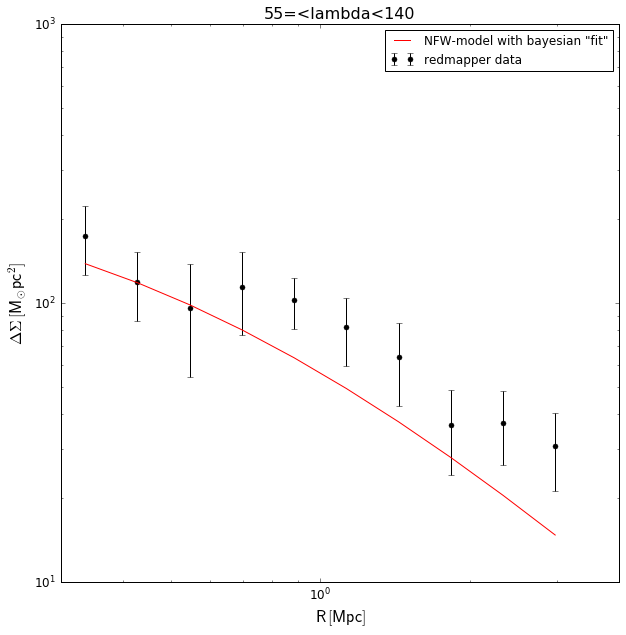

In [52]:
best_m200 = compress_1D_pdf(m200grid,prob_m200_given_data,ci=68,dp=2)[1]
best_c    = compress_1D_pdf(cgrid,prob_c_given_data,ci=68,dp=2)[1] 

#m200grid[j], cgrid[i]

print('Probable values from bayesian inference:', best_m200,best_c)

chisq = ((-1./0.5)*nfw_log_likelihood(R, DSobs, DSerr, (best_m200, best_c)))/(len(R)-2.)
print('Reduced chi^2 from bayesian inference parameters:', chisq)

DStheo_fromfit = DStheo(R, (best_m200,best_c))

plot(R,DSobs,DSerr, DStheo_fromfit, 
     '55=<lambda<140', 'redmapper data', 'NFW-model with nfwsim fit', 'NFW-model with bayesian "fit"')

# MCMC Sampling

* Now we will use MCMC sampling to determine the parameters m200 and c.

* The following piece of code implements the Metropolis algorithm, whose derivation can be read in many textbooks. You can read a brief justification aimed at Phil's grad student self in Chapter 2 of Phil's thesis, for example.


In [53]:
def metropolis(log_posterior, theta, theta_limits, stepsize, nsteps=10000):
    '''
    log_posterior: function of theta 
    theta_limits:  uniform prior ranges
    stepsize:      scalar or vector proposal distribution width
    nsteps:        desired number of samples
    '''
    
    # Start in the center of the prior volume:
    log_prob = log_posterior(theta, x, y, sigmay, theta_limits)
    
    # Store Markov chain as an array of samples:
    chain = np.empty((nsteps, len(theta)))
    log_probs = np.empty(nsteps)
    
    # Count our accepted proposals:
    naccept = 0
    
    for i in range(nsteps):
        
        theta_new = theta + stepsize * np.random.randn(len(theta))
        log_prob_new = log_posterior(theta_new, x, y, sigmay, theta_limits)

        if np.log(np.random.rand()) < (log_prob_new - log_prob):
            # accept, and move to the proposed position:
            theta = theta_new
            log_prob = log_prob_new
            naccept += 1
            
        else:
            # reject, and store the same sample as before:
            pass
        
        chain[i] = theta
        log_probs[i] = log_prob
        
    acceptance_rate = naccept/float(nsteps) 
    
    return chain,log_probs,acceptance_rate

In [54]:
# Initialize m200, c at the center of prior:
m200 = 0.5*(m200limits[0]+m200limits[1])
c = 0.5*(climits[0]+climits[1])
theta = np.array([m200,c])

# Step sizes, 2% or 5% of the prior
m200step = 0.02*(m200limits[1]-m200limits[0])
cstep = 0.05*(climits[1]-climits[0])
stepsize = np.array([m200step,cstep])        
    
# How many steps?
nsteps = 10000
   
print('Running Metropolis Sampler for', nsteps, 'steps...')

chain, log_probs, acceptance_rate = metropolis(
    nfw_log_posterior, theta, theta_limits, stepsize, nsteps=nsteps
)

print('Acceptance fraction:', acceptance_rate)

('Running Metropolis Sampler for', 10000, 'steps...')


NameError: global name 'x' is not defined